In [1]:
from typing import List, Tuple, NamedTuple
from tqdm import trange
import json
import random
from deap import base, creator, tools
from IPython.display import clear_output
import matplotlib.pyplot as plt


Grouping = List[List[int]]
Gene = NamedTuple("Gene", [('project_idxs', List[int]), ('student_idxs', List[int]),])
Indiviual = Tuple[Gene]


## Data helpers

In [2]:
file_path = "data.json"
with open(file_path) as f:
    data = json.load(f)

project_names = list(map(lambda p: p["name"], data["projects"]))
student_names = list(map(lambda s: s["name"], data["students"]))

n_projects = len(data["projects"])
n_students = len(data["students"])
BEST_RATING = 1
WORST_RATING = n_projects + 1

def get_project_name(project_idx):
    return data["projects"][project_idx]["name"]

def get_max_assignements_project(project_idx):
    return data["projects"][project_idx]["max_n_students"]

def get_student_rating(project_idx, student_idx):
    project_name = get_project_name(project_idx)
    student_ratings = data["students"][student_idx]["rating_per_project_name"]
    
    if project_name not in student_ratings:
        return WORST_RATING
    
    return student_ratings[project_name]

def get_student_name(student_idx):
    return data["students"][student_idx]["name"]

def print_grouping(gene: Gene) -> None:
    grouping = create_project_groups(gene)
    for project_idx, group in enumerate(grouping):
        if len(group) > 0:
            print(get_project_name(project_idx))
            for student_idx in group:
                print(f"- {get_student_name(student_idx)} {get_student_rating(project_idx, student_idx)}")
            print()
            
def create_project_groups(gene: Gene) -> Grouping:
    project_idxs, students_idxs = gene.project_idxs, gene.student_idxs
    student_queue = list(students_idxs)
    project_groups = [[] for _ in range(n_projects)]
    
    for project_idx in project_idxs:
        max_assignements = get_max_assignements_project(project_idx)
        project_group = project_groups[project_idx]
        
        while len(project_group) < max_assignements and len(student_queue) > 0:
            student_idx = student_queue.pop()
            project_group.append(student_idx)
            
        if len(student_queue) <= 0:
            break
            
    return project_groups

## Gene creation functions

In [3]:
def create_individual() -> Gene:
    s = list(range(n_students))
    p = list(range(n_projects))
    
    random.shuffle(s)
    random.shuffle(p)
    
    return Gene(student_idxs=s, project_idxs=p)
  
def copy_individual(gene: Gene) -> Gene:
    student_idxs = list(gene.student_idxs)
    project_idxs = list(gene.project_idxs)
    
    return Gene(student_idxs=student_idxs, project_idxs=project_idxs)

## Gene variation functions

In [4]:
def swap_two_indice(l: List):
    i = random.randint(0, len(l) -1)
    j = random.randint(0, len(l) -1)

    l[i], l[j] = l[j], l[i]

def mutate(gene: Indiviual) -> Indiviual:
    if random.choice([True, False]):
        swap_two_indice(gene[0].project_idxs)
    else:
        swap_two_indice(gene[0].student_idxs)
        
    return gene


def cross_over(p1: Indiviual, p2: Indiviual) -> Tuple[Indiviual, Indiviual]:
    tools.cxOrdered(p1[0].student_idxs, p2[0].student_idxs)
    
    return p1, p2

def cross_over2(p1: Indiviual, p2: Indiviual) -> Tuple[Indiviual, Indiviual]:   
    comparision_coss_over(p1[0].student_idxs, p2[0].student_idxs)
    comparision_coss_over(p1[0].project_idxs, p2[0].project_idxs)
    
    return p1, p2
   
def comparision_coss_over(l1: List, l2: List) -> None:  
    is_the_same_list = [g1 == g2 for g1, g2 in zip(l1, l2)]
    possible_values = [g1 for g1, g2 in zip(l1, l2) if g1 != g2]
    possible_values2 = list(possible_values)
    
    random.shuffle(possible_values)
    random.shuffle(possible_values2)
    
    for i, is_the_same in enumerate(is_the_same_list):
        if not is_the_same:
            l1[i] = possible_values.pop()
            l2[i] = possible_values2.pop()

## Evaluation functions

In [5]:
def eval_worst_rating(gene: Gene) -> int:
    grouping = create_project_groups(gene)
    worst_ratings_per_group = []
    for project_idx, group in enumerate(grouping):
        if len(group) > 0:
            ratings_per_group = list(map(lambda student_idx: get_student_rating(project_idx, student_idx), group))
            worst_ratings_per_group.append(max(ratings_per_group))
    
    worst_rating = max(worst_ratings_per_group)
    
    return worst_rating

def eval_worst_rating2(gene: Gene) -> int:
    grouping = create_project_groups(gene)
    worst_ratings = []
    for project_idx, group in enumerate(grouping):
        if len(group) > 0:
            ratings_per_group = list(map(lambda student_idx: 10 ** (get_student_rating(project_idx, student_idx) - 1), group))
            worst_ratings.extend(ratings_per_group)


    return sum(worst_ratings)

def eval_summed_rating(gene: Gene) -> int:
    grouping = create_project_groups(gene)
    s = 0
    for project_idx, group in enumerate(grouping):
        if len(group) > 0:
            ratings_per_group = list(map(lambda student_idx: get_student_rating(project_idx, student_idx) ** 2, group))
            s += sum(ratings_per_group)
    
    return s 


In [6]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox.register("individual", tools.initRepeat, container=creator.Individual, func=create_individual, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", cross_over2)
toolbox.register("mutate", mutate)
#toolbox.register("evaluate", lambda x: tuple([eval_summed_rating(x[0])]))
toolbox.register("evaluate", lambda x: tuple([eval_worst_rating2(x[0])]))
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.individual()

[Gene(project_idxs=[5, 1, 10, 6, 2, 12, 8, 0, 11, 4, 7, 13, 9, 3], student_idxs=[46, 17, 16, 26, 7, 21, 18, 37, 22, 3, 8, 0, 1, 36, 19, 42, 11, 40, 35, 9, 14, 39, 45, 38, 2, 5, 41, 44, 27, 32, 30, 10, 28, 31, 24, 33, 6, 15, 29, 20, 4, 12, 43, 13, 34, 25, 23])]

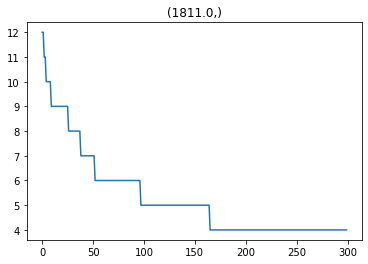

100%|██████████| 300/300 [07:05<00:00,  1.42s/it]


4
167
1811
Can deep learning recognize Lego pieces?
- Noah Jadoenathmisier 2
- Berend Kam 1
- Gijs de Jong 2
- Stef Siekman 2
- Louis Gevers 2

Algorithmic Comparison for the Multi-Agent Path Finding Problem with Waypoints
- Cian Jansen 2
- Arjen Ferwerda 2
- Yaniv Oren 2
- Jeroen van Dijk 1
- Andor Michels 2

Learning and Decision Making for Traffic Control
- Daan den Ouden 2
- David Happel 1
- Pepijn Tersmette 1
- Doreen Mulder 1
- Chris van der Werf 1

Ripple: Improving a Major Decentralized Money Transfer Network
- Marijn Roelvink 2
- Emanuel Kuhn 2
- Wolf Bubberman 1
- Hans Brouwer 3
- Sengim Karayalain 1

Natural Language Modelling for TV shows
- Eric van der Toorn 1
- Johannes IJpma 1
- Wouter van Lil 1
- Pia Keukeleire 1
- Simon Tulling 2
- Dimitri Stallenberg 2
- Katja Schmahl 2

Optimal usage of compute clusters by chaining short jobs
- Thomas van Tussenbroek 3
- Kirti Biharie 1
- Rembrandt Oltmans 2
- Nishad Tahur 1
- Jeroen Galjaard 1

Understanding the role of abstractions

In [7]:
#TODO try other objective functions
pop = toolbox.population(n=10000)
CXPB, MUTPB, NGEN = 0.1, 0.5, 300

# Evaluate the entire population
fitnesses = map(toolbox.evaluate, pop)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit


best_ind = toolbox.population(1)[0]
best_v = toolbox.evaluate(best_ind)
best_restult = eval_worst_rating(best_ind[0])

xs = []
ys = []

for g in trange(NGEN):

    
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        if  fit[0] < best_v[0]:
            best_v = ind.fitness.values
            best_ind = ind
            best_restult = eval_worst_rating(ind[0])
            
        
    xs.append(g)
    ys.append(best_restult)

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    
    clear_output(wait=True)
    plt.plot(xs, ys)
    plt.title(f'{best_ind.fitness.values}')
    plt.show()

#for ind in sorted(pop, key=lambda ind: ind.fitness.values):
#    print(ind.fitness.values)


print(eval_worst_rating(best_ind[0]))
print(eval_summed_rating(best_ind[0]))
print(eval_worst_rating2(best_ind[0]))
print_grouping(best_ind[0])

